In [23]:
import os
import shutil

os.listdir("test") #First find where the ".ipynb_checkpoints" is located.

shutil.rmtree("test/.ipynb_checkpoints")

shutil.rmtree("train/.ipynb_checkpoints")#be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes

In [2]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "train"
training_datagen = ImageDataGenerator(
      rescale = 1./255
      )

VALIDATION_DIR = "test"
validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)


Found 6000 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


In [4]:
import tensorflow as tf

def gimymodel():
  
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.summary()
    return model





In [5]:
#model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [6]:
from sklearn.model_selection import KFold

In [7]:
X_train, X_valid, y_train, y_valid = ([] for i in range(4))

for i in range(train_generator.__len__()):
  x, y = train_generator.next()
  X_train.extend(x)
  y_train.extend(y)
for i in range(validation_generator.__len__()):
  x, y = validation_generator.next()
  X_valid.extend(x)
  y_valid.extend(y)

data = np.concatenate((X_train, X_valid))
label = np.concatenate((y_train, y_valid))


In [8]:
nFolds = 3
kfold = KFold(n_splits=nFolds, shuffle=True)

fold = 0
model, acc, history = ([None] * nFolds for i in range(3))
for train, test in kfold.split(data, label):
  model[fold] = gimymodel()
  model[fold].compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

  print('------------------------------------------------------------------------')
  print(f'Training for fold #{fold + 1} ...')

  history[fold] = model[fold].fit(data[train], label[train],
                                  validation_data = (data[test], label[test]), epochs = 60)
  
  scores = model[fold].evaluate(data[test], label[test], verbose=0)
  acc[fold] = scores[1]
  fold += 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [9]:
best = np.argmax(acc)
model = model[best]
acc = acc[best]
history = history[best]
print(f'Best model was at fold #{best + 1}')

Best model was at fold #1


In [12]:
#history = model.fit(train_generator, epochs=10, validation_data = validation_generator)

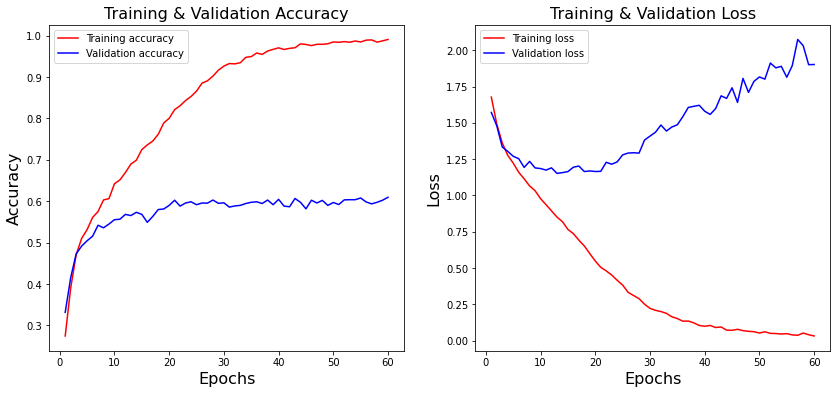

In [13]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()


Classification Report
              precision    recall  f1-score   support

    clapping       0.87      0.82      0.84      1200
     dancing       0.88      0.88      0.88      1200
    drinking       0.83      0.84      0.83      1200
      eating       0.90      0.91      0.91      1200
    fighting       0.86      0.91      0.88      1200
    laughing       0.88      0.86      0.87      1200

    accuracy                           0.87      7200
   macro avg       0.87      0.87      0.87      7200
weighted avg       0.87      0.87      0.87      7200



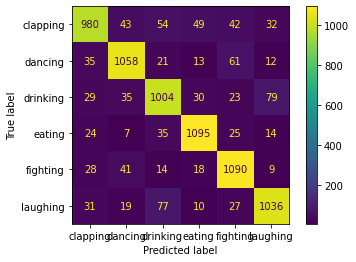

In [14]:
Y_pred=model.predict(data)
#Confution Matrix and Classification Report
y_pred = np.argmax(Y_pred, axis=1)
lab = np.argmax(label, axis=1)
target_names = ['clapping' , 'dancing',  'drinking',  'eating',  'fighting',  'laughing']
print('Classification Report')

print(classification_report(lab, y_pred, target_names=target_names))
import matplotlib.pyplot as plt
from sklearn import metrics



confusion_matrix = metrics.confusion_matrix(lab, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = target_names)

cm_display.plot()
plt.show()


In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-02 19:49:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.190.80, 142.250.190.112, 142.250.190.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.190.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  57.6MB/s    in 1.5s    

2023-01-02 19:49:28 (57.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False


In [17]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [18]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [19]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
def TFmodel():
    
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)                  
    x = layers.Dense  (6, activation='softmax')(x)           

    model = Model(pre_trained_model.input, x) 

    model.summary()
    return model



In [20]:
#model.compile(optimizer = RMSprop(learning_rate=0.0001), 
             # loss = 'categorical_crossentropy', 
              #metrics = ['accuracy'])

In [21]:
#history = model.fit(
           # train_generator,
            #validation_data = validation_generator,
            #epochs = 3)

In [30]:
nFolds = 3
kfold = KFold(n_splits=nFolds, shuffle=True)

fold = 0
model, acc, history = ([None] * nFolds for i in range(3))
for train, test in kfold.split(data, label):
  model[fold] = TFmodel()
  model[fold].compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

  print('------------------------------------------------------------------------')
  print(f'Training for fold #{fold + 1} ...')

  history[fold] = model[fold].fit(data[train], label[train],
                                  validation_data = (data[test], label[test]), epochs = 5)
  
  scores = model[fold].evaluate(data[test], label[test], verbose=0)
  acc[fold] = scores[1]
  fold += 1

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [31]:
best = np.argmax(acc)
model = model[best]
acc = acc[best]
history = history[best]
print(f'Best model was at fold #{best + 1}')

Best model was at fold #3


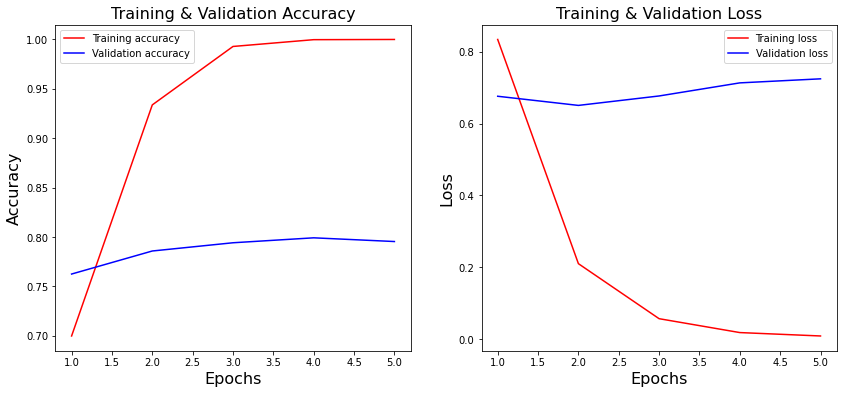

In [32]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()


Classification Report
              precision    recall  f1-score   support

    clapping       0.90      0.90      0.90      1200
     dancing       0.94      0.94      0.94      1200
    drinking       0.93      0.92      0.93      1200
      eating       0.93      0.95      0.94      1200
    fighting       0.94      0.95      0.94      1200
    laughing       0.94      0.94      0.94      1200

    accuracy                           0.93      7200
   macro avg       0.93      0.93      0.93      7200
weighted avg       0.93      0.93      0.93      7200



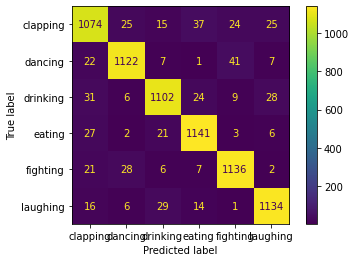

In [33]:
Y_pred=model.predict(data)
#Confution Matrix and Classification Report
y_pred = np.argmax(Y_pred, axis=1)
lab = np.argmax(label, axis=1)
target_names = ['clapping' , 'dancing',  'drinking',  'eating',  'fighting',  'laughing']
print('Classification Report')

print(classification_report(lab, y_pred, target_names=target_names))
import matplotlib.pyplot as plt
from sklearn import metrics



confusion_matrix = metrics.confusion_matrix(lab, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = target_names)

cm_display.plot()
plt.show()
